# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
# !pip install keras --upgrade

In [2]:
# import os
# os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
img_height = 224
img_width = 224

### (1) 라이브러리 불러오기

In [4]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from keras.utils import load_img, img_to_array
import seaborn as sns
import random as rd

In [5]:
def loadImg(img_path):
    images = []

    for path in tqdm(img_path) :
        img = load_img(path, target_size=(img_height, img_width) )
        img = img_to_array(img)
        images.append(img)

    images = np.array(images)
    
    return images

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [6]:
# def download_file(file_id, save_path) :
#     if os.path.exists(save_path) :
#         print(f'{save_path} 파일이 이미 존재합니다.')
#         return

#     gdown.download(id=file_id, output=save_path, quiet=False)

In [7]:
# file_id = '1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W'

# download_file(file_id, 'car_images.zip')

#### 2) 데이터 압축 해제

In [8]:
def dataset_extract(file_name) :
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'./{file_name[:-4]}/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc='Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'./{file_name[:-4]}/')

In [9]:
dataset_extract('Car_Images.zip')

데이터셋 폴더가 이미 존재합니다.


#### 2) 데이터 조회

In [10]:
# 폴더별 이미지 데이터 갯수 확인
normal_path = glob.glob('Car_images/normal/*.png')
abnormal_path = glob.glob('Car_images/abnormal/*.png')

len(normal_path), len(abnormal_path)

(302, 303)

id = 130
다음 그림은 정상 차량입니다.


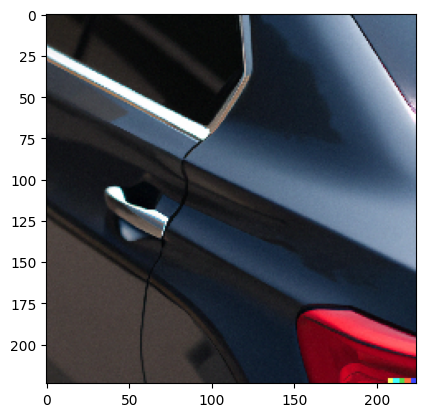

In [11]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
id = rd.randrange(0,len(normal_path))

print(f'id = {id}')
print(f'다음 그림은 정상 차량입니다.')

img = load_img(normal_path[id], target_size=(224, 224))
img = img_to_array(img)
plt.imshow(img/255)
plt.show()

id = 98
다음 그림은 비 정상 차량입니다.


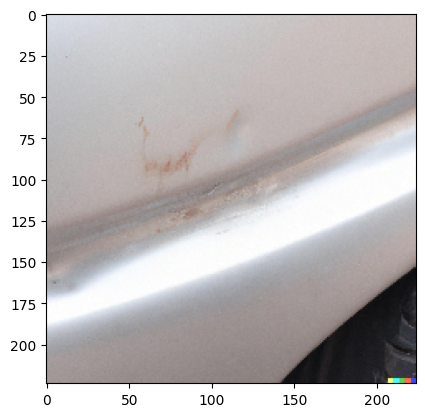

In [12]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
# 정상 차량 랜덤 이미지 확인 및 형태 확인
id = rd.randrange(0, len(abnormal_path))

print(f'id = {id}')
print(f'다음 그림은 비 정상 차량입니다.')

img = load_img(abnormal_path[id], target_size=(224, 224))
img = img_to_array(img)
plt.imshow(img/255)
plt.show()

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [13]:
normal_y = [0] * len(normal_path)
abnormal_y = [1] * len(abnormal_path)

In [14]:
normal_y[:5], abnormal_y[:5]

([0, 0, 0, 0, 0], [1, 1, 1, 1, 1])

In [15]:
len(normal_y), len(abnormal_y)

(302, 303)

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [16]:
x = np.concatenate((normal_path, abnormal_path),axis=0)
y = np.concatenate((normal_y,abnormal_y),axis=0)

In [17]:
y[:5], y[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.1, random_state=1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.1, random_state=1)

In [20]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((489,), (489,), (55,), (55,), (61,), (61,))

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [21]:
train_x = loadImg(train_x) / 255
val_x = loadImg(val_x) / 255
test_x = loadImg(test_x) / 255

100%|██████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 50.48it/s]


In [22]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((489, 224, 224, 3),
 (489,),
 (55, 224, 224, 3),
 (55,),
 (61, 224, 224, 3),
 (61,))

In [23]:
train_x.max()

1.0

### (5) 이미지 데이터 증강 (추가)

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [25]:
aug = ImageDataGenerator(zoom_range=0.1, horizontal_flip=True)  # 10% 확대축소 및 좌우반전
aug.fit(train_x, augment=True)
train_dataset = aug.flow(train_x, train_y)

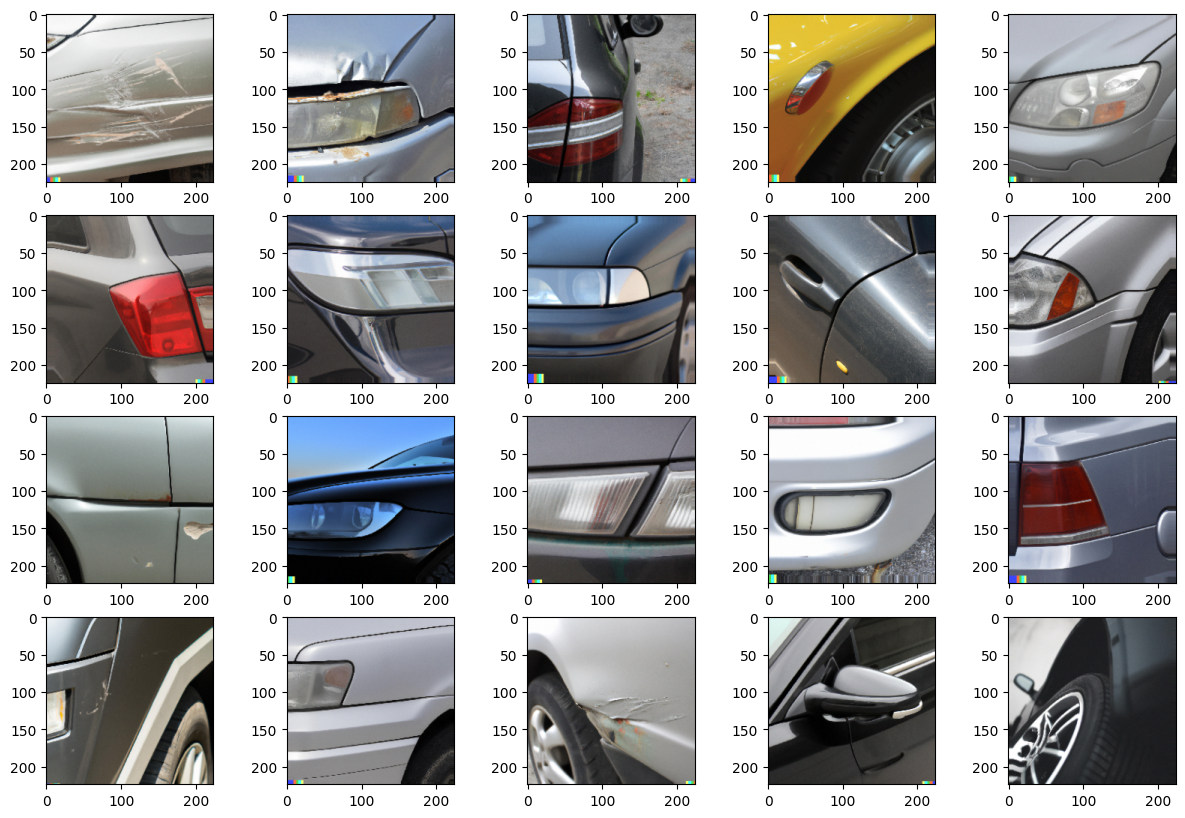

In [26]:
plt.figure(figsize=(15, 10))
for i in range(20): 
    plt.subplot(4, 5, i+1)
    plt.imshow(train_dataset.next()[0][0])
plt.show()

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [27]:
from tensorflow import keras

In [28]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomFlip, RandomCrop, GlobalAveragePooling2D
from keras.backend import clear_session
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#### 1) 구조 설계

In [29]:
clear_session()

il = Input(shape=(img_height, img_width, 3))

hl = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu')(il)
hl = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.4)(hl)

hl = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu')(il)
hl = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.4)(hl)

hl = Flatten()(hl)

hl = Dense(64, activation='relu')(hl)
hl = Dropout(0.25)(hl)

ol = Dense(1, activation='sigmoid')(hl)

model = Model(il, ol)
model.compile(optimizer= "adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten (Flatten)           (None, 802816)            0     

In [30]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [31]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

#### 2) 학습

In [32]:
model.fit(train_dataset, epochs=100, callbacks=[es, lr_reduction], verbose=1, validation_data=(val_x, val_y))

Epoch 1/100
16/16 [==============================] - 3s 147ms/step - loss: 31.0286 - accuracy: 0.6115 - val_loss: 1.5519 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 2s 135ms/step - loss: 4.0852 - accuracy: 0.7014 - val_loss: 0.6269 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 2s 131ms/step - loss: 1.7739 - accuracy: 0.7035 - val_loss: 0.6537 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 2s 132ms/step - loss: 1.1994 - accuracy: 0.7055 - val_loss: 0.7051 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 2s 130ms/step - loss: 0.7934 - accuracy: 0.7587 - val_loss: 0.6501 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 2s 137ms/step - loss: 0.5499 - accuracy: 0.7464 - val_loss: 0.6171 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 2s 133ms/s

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [33]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 50ms/step - loss: 0.4207 - accuracy: 0.8525


[0.4207121431827545, 0.8524590134620667]

In [34]:
y_pred = model.predict(test_x)
y_pred = np.where(y_pred >= .5, 1, 0)

2/2 [==============================] - 0s 6ms/step


In [35]:
y_pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [36]:
test_y[:5]

array([0, 0, 1, 1, 0])

In [37]:
class_names = ['normal', 'abnormal']

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        34
           1       0.91      0.74      0.82        27

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.86      0.85      0.85        61



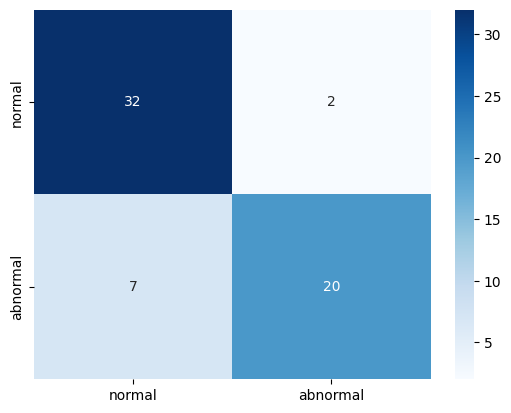

In [38]:
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
print(classification_report(test_y, y_pred))

## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

In [68]:
from keras.utils import image_dataset_from_directory

In [69]:
from keras.layers import Rescaling, RandomRotation

In [70]:
data_dir = './Car_images'

In [71]:
train = image_dataset_from_directory(
        data_dir,
        class_names = class_names,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width))

Found 605 files belonging to 2 classes.
Using 484 files for training.


In [72]:
val = image_dataset_from_directory(
        data_dir,
        class_names = class_names,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width))

Found 605 files belonging to 2 classes.
Using 121 files for validation.


In [73]:
class_names = train.class_names
print(class_names)

['normal', 'abnormal']


In [74]:
normalization_layer = Rescaling(1./255)

In [75]:
normalized_train = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.062184773 1.0


In [76]:
normalized_val = val.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_val))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.094997235 1.0


### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [80]:
from keras.applications.inception_v3 import InceptionV3

In [81]:
clear_session()

data_augmentation = keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    RandomFlip("horizontal")
])
RandomFlip_train = normalized_train.map(lambda x, y: (RandomFlip("horizontal")(x), y))

In [82]:
base_model = InceptionV3(weights='imagenet',       # ImageNet 데이터를 기반으로 미리 학습된 가중치 불러오기
                         include_top=False,        # InceptionV3 모델의 아웃풋 레이어는 제외하고 불러오기
                         input_shape= (img_height, img_width, 3)) # 입력 데이터의 형태

new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(1, activation='sigmoid')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.compile(optimizer= "adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [83]:
print(f'모델의 레이어 수 : {len(model.layers)}')

모델의 레이어 수 : 313


In [84]:
for idx, layer in enumerate(model.layers) :
    if idx < 250 :
        layer.trainable = False
    else :
        layer.trainable = True

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.



#### 3) 학습

In [85]:
model.fit(RandomFlip_train, epochs=100, callbacks=[es, lr_reduction], verbose=1, validation_data=normalized_val)

Epoch 1/100
16/16 [==============================] - 9s 197ms/step - loss: 0.3471 - accuracy: 0.8616 - val_loss: 28.6017 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 2s 116ms/step - loss: 0.2656 - accuracy: 0.8905 - val_loss: 9.9325 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 2s 117ms/step - loss: 0.1749 - accuracy: 0.9401 - val_loss: 4.4791 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.2314 - accuracy: 0.9298 - val_loss: 88.3066 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 2s 116ms/step - loss: 0.0653 - accuracy: 0.9773 - val_loss: 2.7477 - val_accuracy: 0.4959 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 2s 117ms/step - loss: 0.0333 - accuracy: 0.9876 - val_loss: 1.7802 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 2s 109ms/

#### 4) 성능 평가

In [86]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 119ms/step - loss: 0.0376 - accuracy: 0.9836


[0.03762117773294449, 0.9836065769195557]

In [87]:
y_pred = model.predict(test_x)
y_pred = np.where(y_pred >= .5, 1, 0)

2/2 [==============================] - 1s 21ms/step


In [88]:
y_pred[:5]

array([[0],
       [0],
       [1],
       [1],
       [0]])

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.96      1.00      0.98        27

    accuracy                           0.98        61
   macro avg       0.98      0.99      0.98        61
weighted avg       0.98      0.98      0.98        61



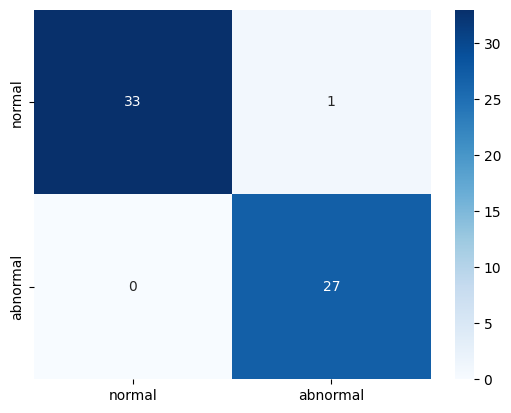

In [89]:
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
print(classification_report(test_y, y_pred))

### VGG16

In [91]:
from tensorflow.keras.applications import VGG16

In [95]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

In [96]:
new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(64, activation='relu')(new_output)
new_output = Dense(1, activation='sigmoid')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.compile(optimizer= "adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [97]:
print(f'모델의 레이어 수 : {len(model.layers)}')

모델의 레이어 수 : 22


In [98]:
# Early Stopping 설정
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [99]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

In [101]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(RandomFlip_train,
                    validation_data=normalized_val,
                    epochs=50,
                    batch_size=10,
                    callbacks=[es, lr_reduction])

Epoch 1/50
16/16 [==============================] - 4s 140ms/step - loss: 0.6360 - accuracy: 0.6550 - val_loss: 0.5589 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 2s 83ms/step - loss: 0.4883 - accuracy: 0.8368 - val_loss: 0.4343 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 2s 81ms/step - loss: 0.4182 - accuracy: 0.8533 - val_loss: 0.3804 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 2s 83ms/step - loss: 0.3600 - accuracy: 0.8760 - val_loss: 0.3482 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 2s 81ms/step - loss: 0.3450 - accuracy: 0.8616 - val_loss: 0.3061 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 2s 82ms/step - loss: 0.3117 - accuracy: 0.8781 - val_loss: 0.2786 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 2s 82ms/step - loss: 0.

In [102]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 1s 673ms/step - loss: 0.0776 - accuracy: 0.9836


[0.07763845473527908, 0.9836065769195557]

In [103]:
y_pred = model.predict(test_x)
y_pred = np.where(y_pred >= .5, 1, 0)

2/2 [==============================] - 0s 39ms/step


In [104]:
y_pred[:5]

array([[0],
       [0],
       [1],
       [1],
       [0]])

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.96      1.00      0.98        27

    accuracy                           0.98        61
   macro avg       0.98      0.99      0.98        61
weighted avg       0.98      0.98      0.98        61



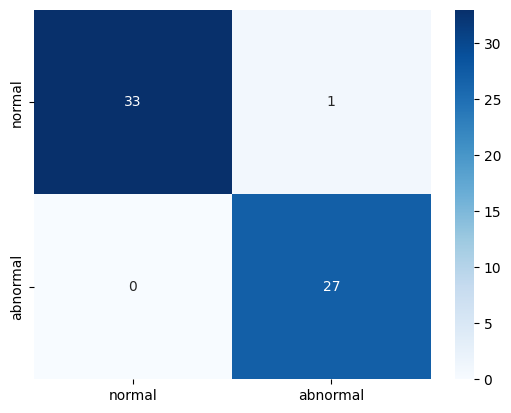

In [105]:
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
print(classification_report(test_y, y_pred))

### ResNet50

In [188]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras import models

In [210]:
# ResNet50 모델 로드, ImageNet 데이터 기반으로 사전 학습된 가중치 사용
# 최상위 레이어는 제외하고 로드, 입력 데이터 형태를 ResNet50의 표준인 224x224x3으로 설정
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [211]:
print(f'모델의 레이어 수 : {len(base_model.layers)}')

모델의 레이어 수 : 175


In [212]:
# 새로운 모델의 출력 레이어 추가
new_output = Flatten()(base_model.output)
new_output = Dense(64, activation='relu')(new_output)
new_output = Dense(1, activation='sigmoid')(new_output)

# 새로운 모델 구성
model = models.Model(inputs=base_model.inputs, outputs=new_output)

# 모델 컴파일
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [213]:
# Early Stopping 설정
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [214]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

In [215]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(RandomFlip_train,
                    validation_data=normalized_val,
                    epochs=100,
                    batch_size=10,
                    callbacks=[es, lr_reduction])

Epoch 1/100
16/16 [==============================] - 5s 121ms/step - loss: 2.6543 - accuracy: 0.5248 - val_loss: 1.0414 - val_accuracy: 0.5207 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 2s 75ms/step - loss: 0.7821 - accuracy: 0.6012 - val_loss: 0.7154 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 2s 77ms/step - loss: 0.5292 - accuracy: 0.7500 - val_loss: 0.5617 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 2s 72ms/step - loss: 0.4774 - accuracy: 0.7707 - val_loss: 0.6181 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 2s 71ms/step - loss: 0.5020 - accuracy: 0.7665 - val_loss: 0.6138 - val_accuracy: 0.6942 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 2s 77ms/step - loss: 0.4523 - accuracy: 0.8017 - val_loss: 0.5391 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 2s 78ms/step - l

In [216]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 28ms/step - loss: 0.1463 - accuracy: 0.9672


[0.1462596207857132, 0.9672130942344666]

In [217]:
y_pred = model.predict(test_x)
y_pred = np.where(y_pred >= .5, 1, 0)

2/2 [==============================] - 1s 28ms/step


In [218]:
y_pred[:5]

array([[0],
       [0],
       [1],
       [1],
       [0]])

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.96      0.96      0.96        27

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



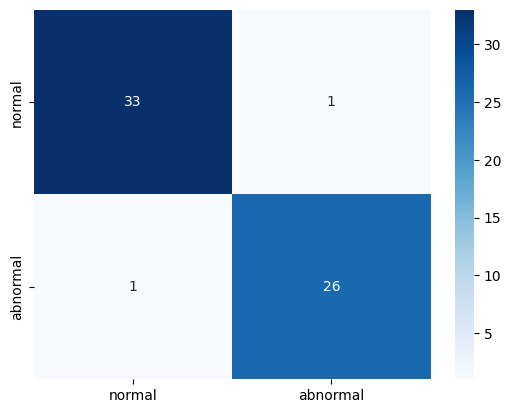

In [219]:
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
print(classification_report(test_y, y_pred))

### MobileNetV3

In [220]:
model4 = keras.applications.MobileNetV3Small(
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    pooling='avg ',
    dropout_rate=0.2,
    include_preprocessing = False
)

4334752/4334752 [==============================] - 0s 0us/step


In [221]:
for i, layer in enumerate(model4.layers):
    if i <= 60:
        layer.trainable = False
    else:
        layer.trainable = True

In [224]:
model4_1 = keras.Sequential([
    model4,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # 출력 레이어 추가
])

In [225]:
# Early Stopping 설정
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [226]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

In [227]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(RandomFlip_train,
                    validation_data=normalized_val,
                    epochs=50,
                    batch_size=10,
                    callbacks=[es, lr_reduction])

Epoch 1/50
16/16 [==============================] - 4s 119ms/step - loss: 0.3906 - accuracy: 0.8471 - val_loss: 0.5237 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 2s 78ms/step - loss: 0.1778 - accuracy: 0.9483 - val_loss: 0.4817 - val_accuracy: 0.7934 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 2s 70ms/step - loss: 0.1434 - accuracy: 0.9607 - val_loss: 0.4973 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 2s 79ms/step - loss: 0.1775 - accuracy: 0.9360 - val_loss: 0.4698 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 2s 70ms/step - loss: 0.1377 - accuracy: 0.9628 - val_loss: 0.5508 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 2s 69ms/step - loss: 0.1421 - accuracy: 0.9669 - val_loss: 0.5239 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 2s 73ms/step - loss: 0.

In [228]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 29ms/step - loss: 0.1424 - accuracy: 0.9672


[0.14243413507938385, 0.9672130942344666]

In [229]:
y_pred = model.predict(test_x)
y_pred = np.where(y_pred >= .5, 1, 0)

2/2 [==============================] - 1s 27ms/step


In [230]:
y_pred[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]])

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.93      0.96        27

    accuracy                           0.97        61
   macro avg       0.97      0.96      0.97        61
weighted avg       0.97      0.97      0.97        61



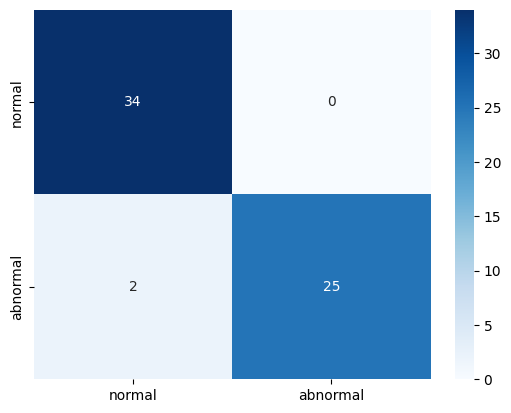

In [231]:
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
print(classification_report(test_y, y_pred))